This notebook demonstrates how to use `pretrained-microscopy-models` to perform binary segmentation on environmental barrier coating data. This is the EBC-1 dataset in the accompanying paper.

In [ ]:
import sys
!{sys.executable} -m pip install "git+https://github.com/nasa/pretrained-microscopy-models"
!{sys.executable} -m pip install scikit-learn

  Cloning https://github.com/nasa/pretrained-microscopy-models to /private/var/folders/sd/jk47_l8x5sg_29vw8ls1ch180000gn/T/pip-req-build-t22v1psc
  Running command git clone --filter=blob:none --quiet https://github.com/nasa/pretrained-microscopy-models /private/var/folders/sd/jk47_l8x5sg_29vw8ls1ch180000gn/T/pip-req-build-t22v1psc
  Resolved https://github.com/nasa/pretrained-microscopy-models to commit 9b7c4abc1321e81eca7a68d548e5371676fa74fa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached segmentation_models_pytorch-0.2.1-py3-none-any.whl.metadata (26 kB)
  Using cached albumentations-2.0.8-py3-none-any.whl.metadata (43 kB)
  Using cached pretrainedmodels-0.7.4.tar.gz (58 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached efficientnet_pytorch-0.6.3.tar.gz (16 kB)
  Installing build

In [33]:
import os
import torch
import cv2
import random
import imageio

import numpy as np
import matplotlib.pyplot as plt
import pretrained_microscopy_models as pmm
import segmentation_models_pytorch as smp
import albumentations as albu
from skimage import img_as_ubyte
from skimage.color import gray2rgb

from pathlib import Path
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import random, shutil

In [34]:
DATA_DIR = "/Users/chasekatz/Desktop/ML-Microscopy-Hackathon/Images/Splitting"
Defects = ['Keyhole', 'Lack_of_Fusion', 'Process_Pores']
Defect = Defects[0]

In [35]:
# set random seeds for repeatability
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

## ML Model

In [37]:
# model parameters
architecture = 'UnetPlusPlus'
encoder = 'se_resnext50_32x4d'
pretrained_weights = 'micronet'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create the UnetPlusPlus model with a se_resnext50_32x4d backbone 
# that is pre-trained on micronet
model = pmm.segmentation_training.create_segmentation_model(
    architecture=architecture,
    encoder = encoder,
    encoder_weights=pretrained_weights, # use encoder pre-trained on micronet
    classes=1 # Set 1 for binary classification (the background class is implicit)
    )

## Dataset

Note that the example annotations appear black because the pixel values are
0, 1, and 2 out of 255.

In [38]:
for i in Defects:
    os.makedirs(os.path.join(DATA_DIR, i), exist_ok=True)
    for j in 'train', 'val', 'test', 'train_annot', 'val_annot', 'test_annot':
        os.makedirs(os.path.join(DATA_DIR, i, j), exist_ok=True)

split = {"train": 0.7, "val": 0.15, "test": 0.15}

labeled = Path('/Users/chasekatz/Desktop/ML-Microscopy-Hackathon/Images/Cropped images')
unlabeled = Path(f'/Users/chasekatz/Desktop/ML-Microscopy-Hackathon/Images/Labeled_Defects/{Defect}')
OUT = Path(os.path.join(DATA_DIR, Defect))

exts = {".png", ".jpg", ".jpeg", ".tif", ".tiff"}
random.seed(42)

def copy_split(src_folder: Path, out_map: dict):
    files = [p for p in src_folder.iterdir() if p.suffix.lower() in exts]
    random.shuffle(files)
    n = len(files)
    n_train = int(split["train"] * n)
    n_val   = int(split["val"] * n)

    chunks = {
        "train": files[:n_train],
        "val":   files[n_train:n_train+n_val],
        "test":  files[n_train+n_val:],
    }
    for k, ps in chunks.items():
        for p in ps:
            shutil.copy2(p, OUT / out_map[k] / p.name)

# unlabeled → train/val/test
copy_split(unlabeled, {"train":"train", "val":"val", "test":"test"})
# labeled → train_annot/val_annot/test_annot
copy_split(labeled, {"train":"train_annot", "val":"val_annot", "test":"test_annot"})
    

In [39]:
x_train_dir = os.path.join(OUT, 'train')
y_train_dir = os.path.join(OUT, 'train_annot')

x_valid_dir = os.path.join(OUT, 'val')
y_valid_dir = os.path.join(OUT, 'val_annot')

x_test_dir = os.path.join(OUT, 'test')
y_test_dir = os.path.join(OUT, 'test_annot')

#### Image Augmentation
Adding noise, contrast, random crops, flipping and other image augmentations can artifically augment the training dataset and make the model more robust to changes in these conditions

In [40]:
def get_training_augmentation(prob=0.3, power=1):
    """Need to make sure image shape is divisible by 32"""
    train_transform = [
        albu.HorizontalFlip(p=0.5), #only horizontal to preserve orientation
        albu.RandomCrop(512, 512),
        albu.GaussNoise(p=0.5),
        albu.RandomBrightnessContrast(p=0.3),

        albu.OneOf(
            [
                albu.Sharpen(p=1, alpha=(0.2, 0.5*power)),
                albu.Blur(blur_limit=3*power, p=1),
            ],
            p=0.3,
        ),
        
    ]

    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Need to make sure image shape is divisible by 32"""
    test_transform = [
        # instead of center cropping we will crop a little lower in the 
        # validation data to more accurately capture where the oxide layer is.
        albu.Crop(256, 256+100, 768, 768+100)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

### Create datasets

In [42]:
# how the images will be normalized. Use imagenet statistics even on micronet pre-training
preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder, 'imagenet') 

# pixel values of the annotations for each mask.
# Note: for binary classification we only need to specify the forground class.
# Note 2: cracks are also annotated seperately, but we are ignoring them in this example.
class_values = {Defect: [1]}


# For multiclass segmentation we can pass the directory for images and masks.
# because they follow the naming convention "image1.tif" and "image1_mask.tif"
# in this case we need to pass the list of image and annotation paths explicitly
# because the annotation data does not follow that naming convention
train_images = [os.path.join(x_train_dir, image_id) for image_id in os.listdir(x_train_dir)]
train_masks = [os.path.join(y_train_dir, image_id) for image_id in os.listdir(y_train_dir)]

valid_images = [os.path.join(x_valid_dir, image_id) for image_id in os.listdir(x_valid_dir)]
valid_masks = [os.path.join(y_valid_dir, image_id) for image_id in os.listdir(y_valid_dir)]

test_images = [os.path.join(x_test_dir, image_id) for image_id in os.listdir(x_test_dir)]
test_masks = [os.path.join(y_test_dir, image_id) for image_id in os.listdir(y_test_dir)]


training_dataset = pmm.io.Dataset(
    images=train_images,
    masks=train_masks,
    class_values=class_values,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)

validation_dataset = pmm.io.Dataset(
    images=valid_images,
    masks=valid_masks,
    class_values=class_values,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)

test_dataset = pmm.io.Dataset(
    images=test_images,
    masks=test_masks,
    class_values=class_values,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)

### Visualize datasets

In [43]:
### validation data

# we need to remove pre_processing to see the data
visualize_dataset = pmm.io.Dataset(
    images=valid_images,
    masks=valid_masks,
    class_values=class_values,
    augmentation=get_validation_augmentation(),
)

for im, mask in visualize_dataset:
    pmm.util.visualize(
        image=im,
        oxide_mask=mask.squeeze(),
    )


ValueError: Height and Width of image, mask or masks should be equal. You can disable shapes check by setting a parameter is_check_shapes=False of Compose class (do it only if you are sure about your data consistency).

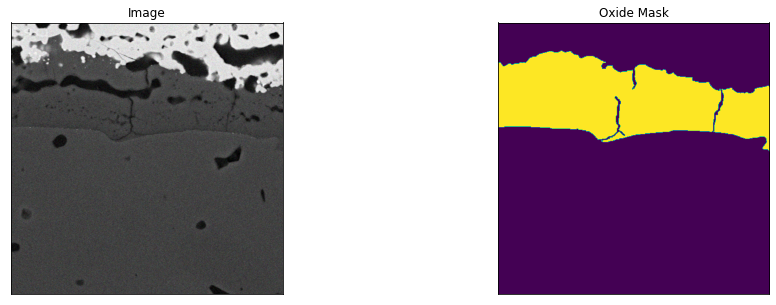

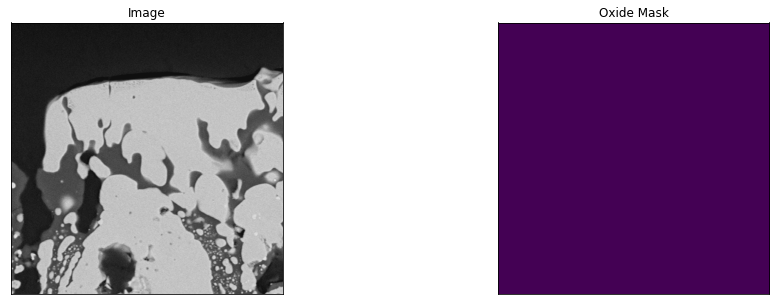

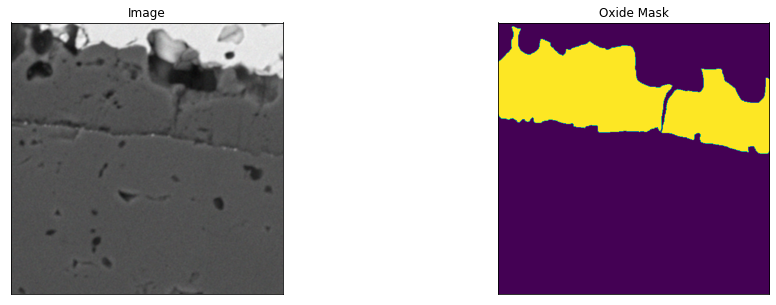

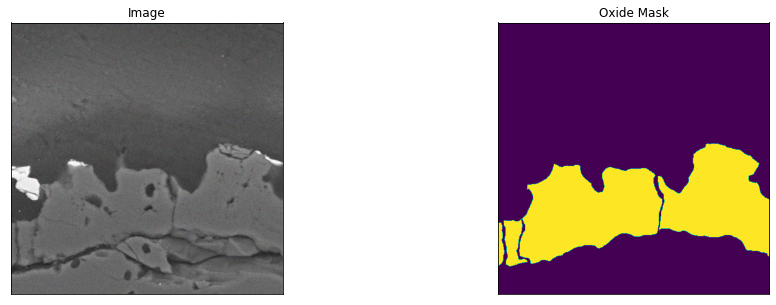

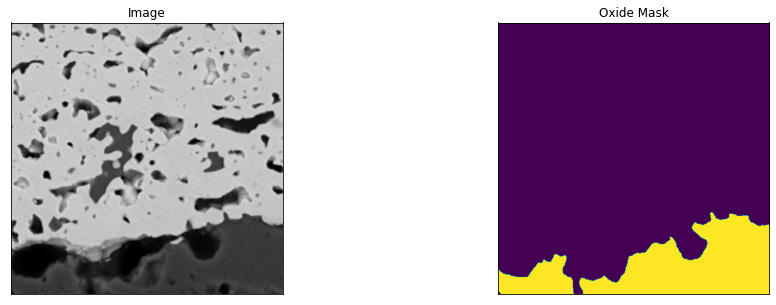

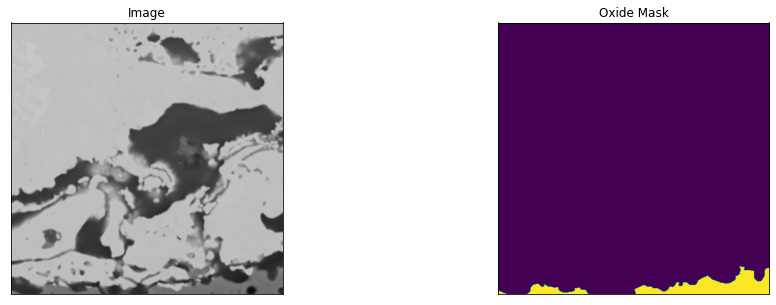

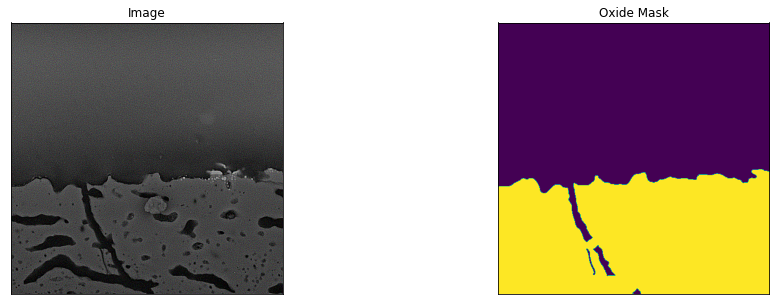

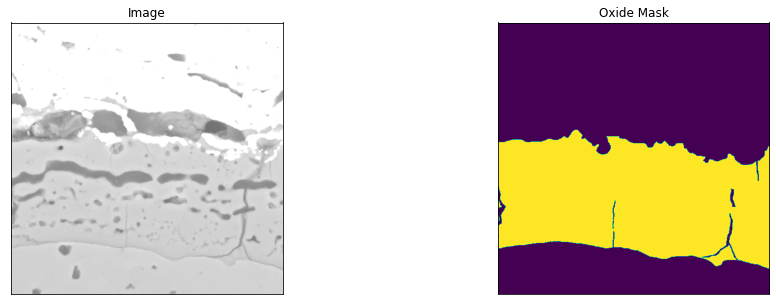

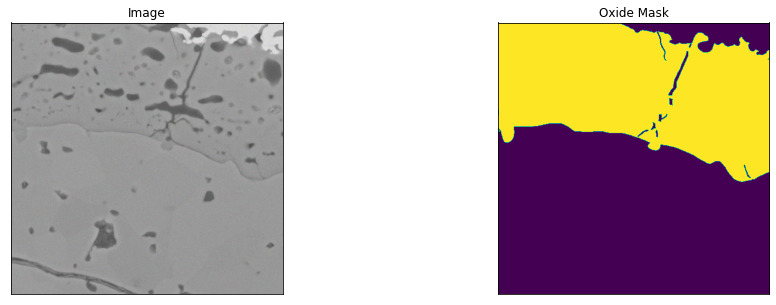

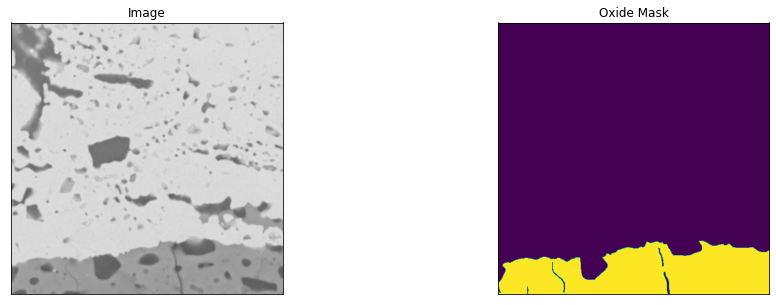

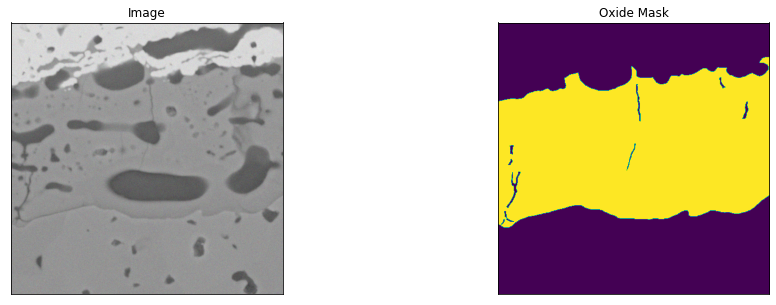

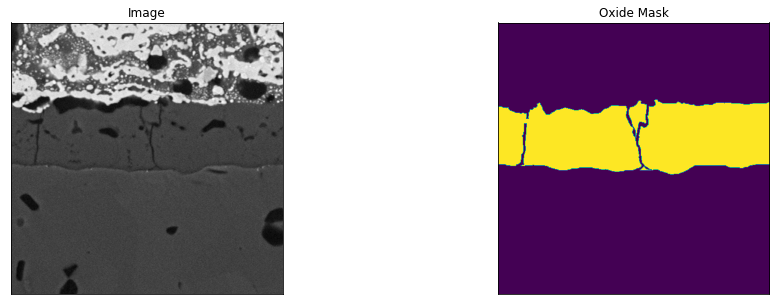

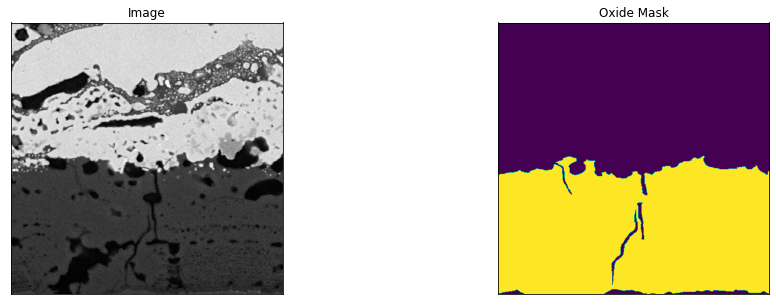

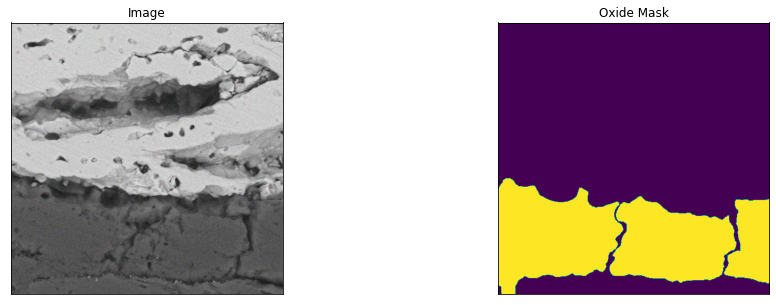

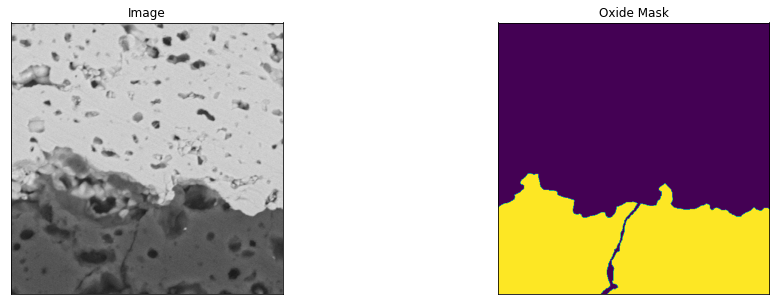

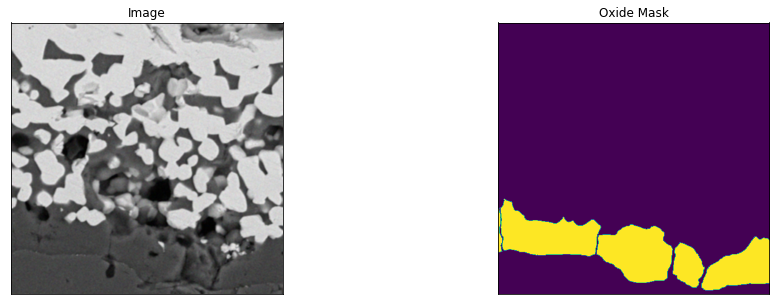

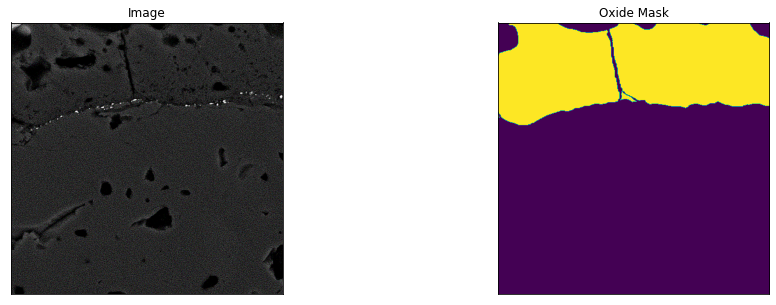

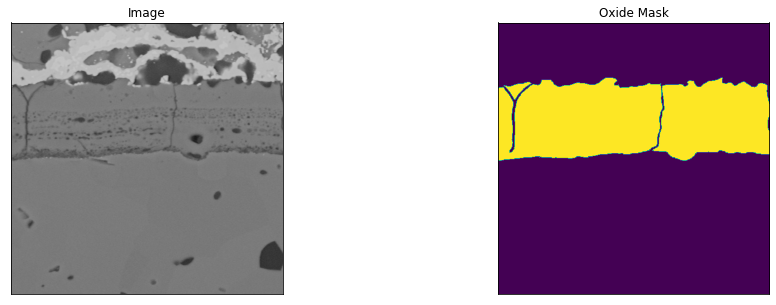

In [11]:
### training data

# we need to remove pre_processing to see the data
visualize_dataset = pmm.io.Dataset(
    images=train_images,
    masks=train_masks,
    class_values=class_values,
    augmentation=get_training_augmentation(),
)

for im, mask in visualize_dataset:
    pmm.util.visualize(
        image=im,
        oxide_mask=mask.squeeze(),
    )


## Train ML Model

In [12]:
state = pmm.segmentation_training.train_segmentation_model(
    model=model,
    architecture=architecture,
    encoder=encoder,
    train_dataset=training_dataset,
    validation_dataset=validation_dataset,
    class_values=class_values,
    device=device, 
    patience=30,
    lr=2e-4,
    batch_size=6,
    val_batch_size=6,
    save_folder='models',
    save_name='binary_segmentation_example.pth.tar'
)


Epoch: 0, lr: 0.00020000, time: 0.00 seconds, patience step: 0, best iou: 0.0000
train:   0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\jstuckne\Anaconda3\envs\test_pmm7\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


valid: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, DiceBCELoss - 0.6578, iou_score - 0.5803]
Best model saved!

Epoch: 1, lr: 0.00020000, time: 22.27 seconds, patience step: 0, best iou: 0.5803
valid: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s, DiceBCELoss - 0.5979, iou_score - 0.7784]
Best model saved!

Epoch: 2, lr: 0.00020000, time: 12.55 seconds, patience step: 0, best iou: 0.7784
valid: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s, DiceBCELoss - 0.5847, iou_score - 0.8157]
Best model saved!

Epoch: 3, lr: 0.00020000, time: 11.30 seconds, patience step: 0, best iou: 0.8157
valid: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s, DiceBCELoss - 0.5666, iou_score - 0.871]
Best model saved!

Epoch: 4, lr: 0.00020000, time: 12.96 seconds, patience step: 0, best iou: 0.8710
valid: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s, DiceBCELoss - 0.5553, iou_score - 0.8912]
Best model saved!

Epoch: 5, lr: 0.00020000, time: 11.43 seconds, patience step: 0, best iou: 0.8912
valid: 100%|█████████

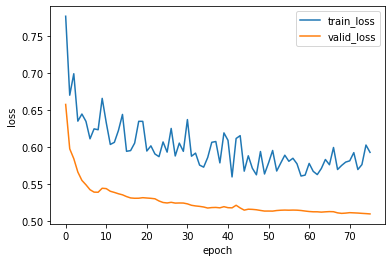

In [13]:
plt.plot(state['train_loss'], label='train_loss')
plt.plot(state['valid_loss'], label='valid_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [14]:
# drop the learning rate and keep training to see if we can squeeze a little more out.
model_path = Path('models', 'binary_segmentation_example.pth.tar')
state = pmm.segmentation_training.train_segmentation_model(
    model=str(model_path),
    architecture=architecture,
    encoder=encoder,
    patience=30,
    lr=1e-5,
    batch_size=6,
    val_batch_size=6,
    train_dataset=training_dataset,
    validation_dataset=validation_dataset,
    class_values=class_values,
    save_folder='models',
    save_name='binary_segmentation_example_low_lr.pth.tar'
)


Epoch: 0, lr: 0.00001000, time: 0.00 seconds, patience step: 0, best iou: 0.0000
valid: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s, DiceBCELoss - 0.5157, iou_score - 0.9604]
Best model saved!

Epoch: 1, lr: 0.00001000, time: 12.51 seconds, patience step: 0, best iou: 0.9604
valid: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s, DiceBCELoss - 0.5152, iou_score - 0.957]

Epoch: 2, lr: 0.00001000, time: 17.96 seconds, patience step: 1, best iou: 0.9604
valid: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s, DiceBCELoss - 0.515, iou_score - 0.9557]

Epoch: 3, lr: 0.00001000, time: 16.90 seconds, patience step: 2, best iou: 0.9604
valid: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s, DiceBCELoss - 0.515, iou_score - 0.9574]

Epoch: 4, lr: 0.00001000, time: 18.02 seconds, patience step: 3, best iou: 0.9604
valid: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s, DiceBCELoss - 0.5149, iou_score - 0.9574]

Epoch: 5, lr: 0.00001000, time: 16.84 seconds, patience step: 4, best iou: 0.9604
valid: 100%|█

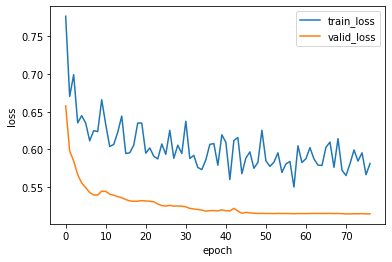

In [15]:
plt.plot(state['train_loss'], label='train_loss')
plt.plot(state['valid_loss'], label='valid_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Evaluate Performance

In [ ]:
# load best model
best_model_path = Path('models', 'binary_segmentation_example_low_lr.pth.tar')
state = torch.load(best_model_path, weights_only=False) 
best_model = pmm.segmentation_training.create_segmentation_model(
    architecture=architecture,
    encoder = encoder,
    encoder_weights=pretrained_weights, # use encoder pre-trained on micronet
    classes=1 # secondary precipitates, tertiary precipitates, matrix
    )
best_model.load_state_dict(pmm.util.remove_module_from_state_dict(state['state_dict']))

<All keys matched successfully>

In [17]:
# create test dataset
test_dataset = pmm.io.Dataset(
    test_images, 
    test_masks, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_values=class_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset without transformations for image visualization
test_dataset_vis = pmm.io.Dataset(
    test_images, test_masks, 
    class_values=class_values,
)

In [18]:
# evaluate model on test set
loss = pmm.losses.DiceBCELoss(weight=0.7)
metrics = [smp.utils.metrics.IoU(threshold=0.5),]
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device='cuda',
)

logs = test_epoch.run(test_dataloader)

valid:  33%|███▎      | 1/3 [00:00<00:00,  5.98it/s, DiceBCELoss - 0.5947, iou_score - 0.9615]

c:\Users\jstuckne\Anaconda3\envs\test_pmm7\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


valid: 100%|██████████| 3/3 [00:00<00:00,  5.63it/s, DiceBCELoss - 0.5839, iou_score - 0.9413]


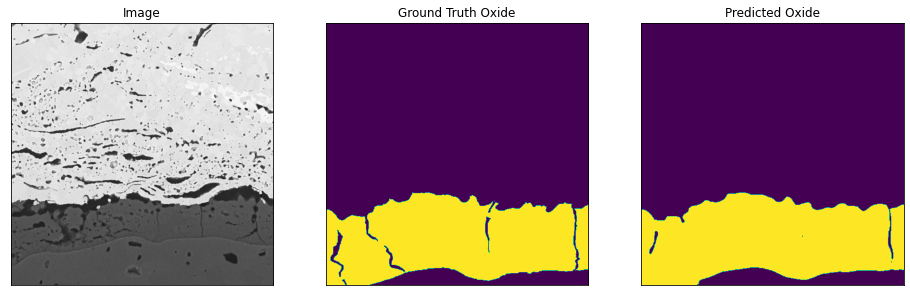

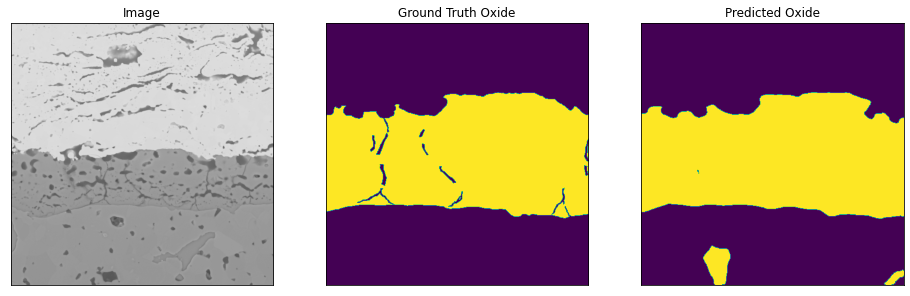

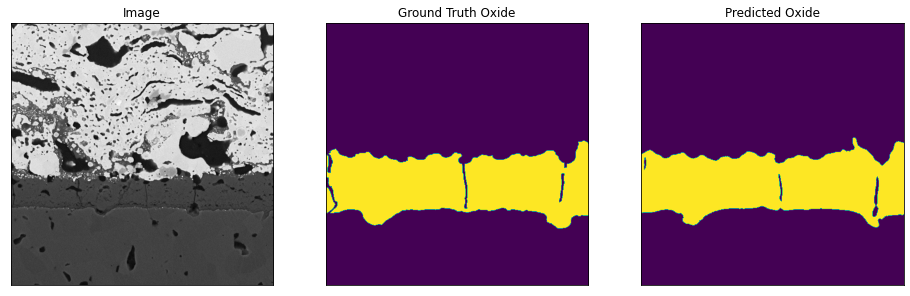

In [22]:
for n in range(len(test_dataset)):
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    gt_mask = gt_mask[0, :, :] # remove single dimension to visualize
    
    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    pmm.util.visualize(
        image=image_vis, 
        ground_truth_oxide=gt_mask,
        predicted_oxide=pr_mask,
    )

## Inference

In [23]:
model_path = Path('models', 'binary_segmentation_example_low_lr.pth.tar')
model, preprocessing_fn = pmm.segmentation_training.load_segmentation_model(model_path, classes=1)

In [ ]:
import warnings
def compare(prediction, truth, labels):
    out = np.zeros(truth.shape, dtype='uint8')
    trues = [np.all(truth == v, axis=-1) for v in labels]
    preds = [prediction[:,:,i] for i in range(prediction.shape[2])]
    for t, p in zip(trues, preds):
        out[t & p, :] = [255, 255, 255] # true posative
        out[t & ~p, :] = [255, 0, 255] # false negative
        out[~t & p, :] = [0, 255, 255] # false posative       
    return out

def load_model(model_path, class_values = {'background': 0, 'oxide': 1, 'crack': 2}):
    model_data = torch.load(model_path, weights_only=False)
    #DEVICE = 'cuda'
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    decoder = model_data['decoder']
    encoder = model_data['encoder']
    #class_values = best_model['class_values']
    
    activation = 'softmax2d' if len(class_values) > 1 else 'sigmoid' #'softmax2d' for multicalss segmentation
    try:
        preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder, 'imagenet')
    except ValueError:
        preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder, 'imagenet+5k')
    model = getattr(smp, decoder)(encoder_name=encoder, 
                                          encoder_weights=None,
                                          classes=len(class_values),
                                          activation=activation)

    model.load_state_dict(pmm.util.remove_module_from_state_dict(model_data['state_dict']))
    model.eval()
    return model, preprocessing_fn

#-----helper function to split data into batches
def divide_batch(l, n): 
    for i in range(0, l.shape[0], n):  
        yield l[i:i + n,::] 

# https://github.com/choosehappy/PytorchDigitalPathology
def segmentation_models_inference(io, model, preprocessing_fn, device = None, batch_size = 8, patch_size = 512,
                                  num_classes=3, probabilities=None):

    # This will not output the first class and assumes that the first class is wherever the other classes are not!

    io = preprocessing_fn(io)
    io_shape_orig = np.array(io.shape)
    stride_size = patch_size // 2
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # add half the stride as padding around the image, so that we can crop it away later
    io = np.pad(io, [(stride_size // 2, stride_size // 2), (stride_size // 2, stride_size // 2), (0, 0)],
                mode="reflect")

    io_shape_wpad = np.array(io.shape)

    # pad to match an exact multiple of unet patch size, otherwise last row/column are lost
    npad0 = int(np.ceil(io_shape_wpad[0] / patch_size) * patch_size - io_shape_wpad[0])
    npad1 = int(np.ceil(io_shape_wpad[1] / patch_size) * patch_size - io_shape_wpad[1])

    io = np.pad(io, [(0, npad0), (0, npad1), (0, 0)], mode="constant")

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        arr_out = pmm.segmentation_training.extract_patches(io, (patch_size, patch_size, 3), stride_size)

    arr_out_shape = arr_out.shape
    arr_out = arr_out.reshape(-1, patch_size, patch_size, 3)

    # in case we have a large network, lets cut the list of tiles into batches
    output = np.zeros((0, num_classes, patch_size, patch_size))
    for batch_arr in divide_batch(arr_out, batch_size):
        arr_out_gpu = torch.from_numpy(batch_arr.transpose(0, 3, 1, 2).astype('float32')).to(device)

        # ---- get results
        output_batch = model.predict(arr_out_gpu)

        # --- pull from GPU and append to rest of output
        if probabilities is None:
            output_batch = output_batch.detach().cpu().numpy().round()
        else:
            output_batch = output_batch.detach().cpu().numpy()

        output = np.append(output, output_batch, axis=0)

    output = output.transpose((0, 2, 3, 1))

    # turn from a single list into a matrix of tiles
    output = output.reshape(arr_out_shape[0], arr_out_shape[1], patch_size, patch_size, output.shape[3])

    # remove the padding from each tile, we only keep the center
    output = output[:, :, stride_size // 2:-stride_size // 2, stride_size // 2:-stride_size // 2, :]

    # turn all the tiles into an image
    output = np.concatenate(np.concatenate(output, 1), 1)

    # incase there was extra padding to get a multiple of patch size, remove that as well
    output = output[0:io_shape_orig[0], 0:io_shape_orig[1], :]  # remove paddind, crop back

    if probabilities is None:
        if num_classes == 1:
            return output.astype('bool')
        else:
            return output[:, :, 1:].astype('bool')
    else:
        if num_classes == 1:
            output[:,:,0] = output[:,:,0] > probabilities
            return output.astype('bool')
        else:
            for i in range(num_classes-1): #don't care about background class
                output[:,:,i+1] = output[:,:,i+1] > probabilities[i]
            return output[:, :, 1:].astype('bool')

In [63]:
im_path = test_images[0]
annot_path = test_masks[0]
im = imageio.imread(im_path)
im = img_as_ubyte(im)
truth = imageio.imread(annot_path)
truth = img_as_ubyte(truth)
pred = segmentation_models_inference(im, model, preprocessing_fn, batch_size=4, patch_size=512, num_classes=1)

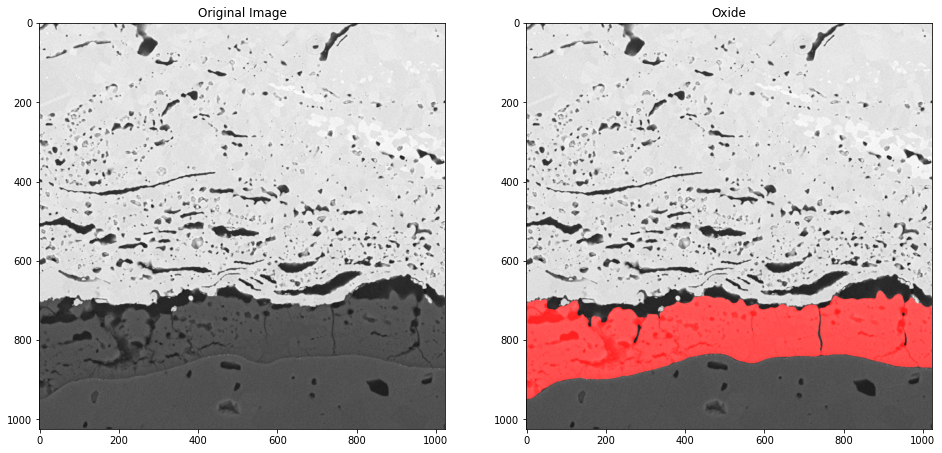

In [65]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16,16))
oxide = im.copy()
oxide[pred[:, :, 0], 0] = 255
ax0.imshow(im)
ax0.set_title('Original Image')
ax1.imshow(oxide)
ax1.set_title('Oxide');



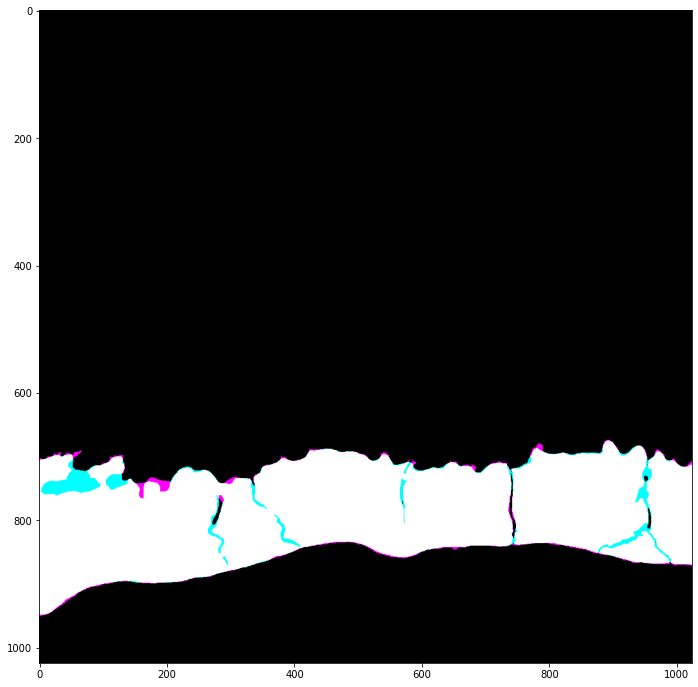

In [70]:
labels = [1]
truth = gray2rgb(truth)
visual = pmm.segmentation_training.visualize_prediction_accuracy(pred, truth, labels)
plt.figure(figsize=(12,12))
plt.imshow(visual);